In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       

from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, concatenate

from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam

from keras.models import load_model


In [2]:
dataset = pd.read_csv('data\driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
NUMBER_CLASSES = 10 # 10 classes
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('./data/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('./data/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [4]:
img_rows = 64 
img_cols = 64
color_type = 1 
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:05<00:45,  5.07s/it]

Loading directory c1


 20%|██        | 2/10 [00:09<00:39,  4.90s/it]

Loading directory c2


 30%|███       | 3/10 [00:14<00:33,  4.83s/it]

Loading directory c3


 40%|████      | 4/10 [00:19<00:28,  4.80s/it]

Loading directory c4


 50%|█████     | 5/10 [00:24<00:24,  4.82s/it]

Loading directory c5


 60%|██████    | 6/10 [00:28<00:18,  4.75s/it]

Loading directory c6


 70%|███████   | 7/10 [00:33<00:14,  4.71s/it]

Loading directory c7


 80%|████████  | 8/10 [00:37<00:09,  4.50s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:41<00:04,  4.29s/it]

Loading directory c9


  0%|          | 200/79726 [00:00<03:11, 415.05it/s]


In [5]:
import plotly.express as px

px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

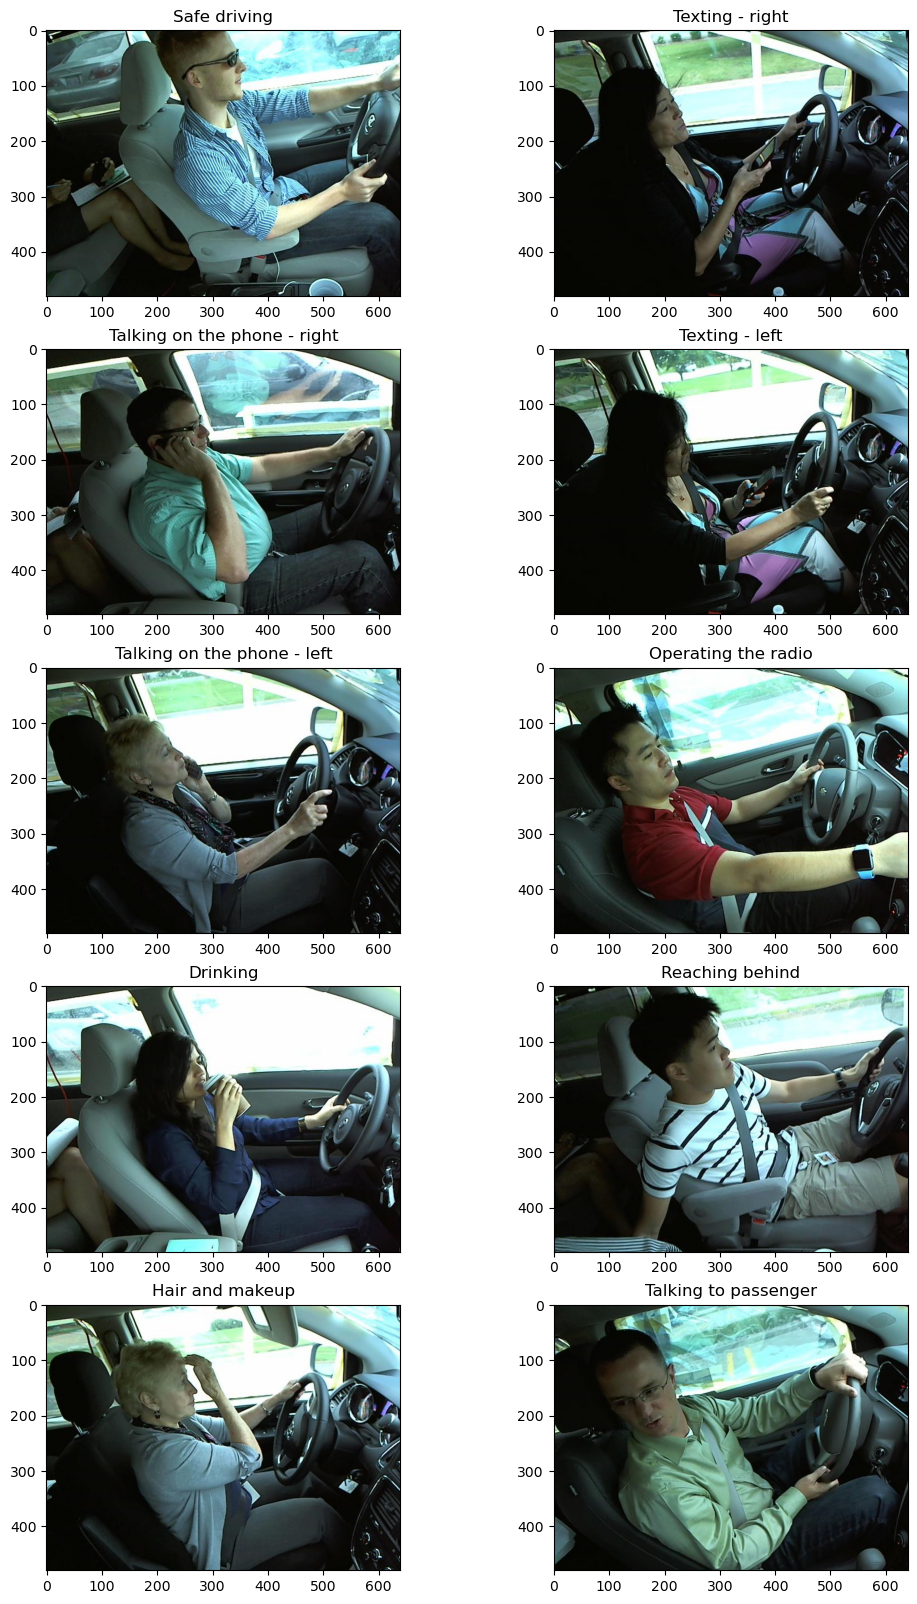

In [6]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './data/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [7]:
#inception model 

def create_inception_model():
    inputs = Input(shape=(img_rows, img_cols, color_type))
    
    tower_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(inputs)
    tower_1 = Conv2D(32, (5, 5), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(32, (1, 1), padding='same', activation='relu')(inputs)
    tower_2 = Conv2D(32, (3, 3), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Conv2D(32, (1, 1), padding='same', activation='relu')(tower_3)

    x = concatenate([tower_1, tower_2, tower_3], axis=-1)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
model = create_inception_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           64        ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 32)           64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 1)            0         ['input_1[0][0]']             
 D)                                                                                         

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:

history = model.fit(x_train, y_train,validation_data=(x_test, y_test),
          epochs=10, batch_size=64, verbose=1,callbacks=callback)

model.save('newmodel_1.h5')

val_loss , Accurecy = model.evaluate(x_test , y_test)

print(f"Accurecy = {Accurecy * 100 :.2f} %")

Epoch 1/10


281/281 [==============================] - 168s 585ms/step - loss: 1.2967 - accuracy: 0.5747 - val_loss: 1.3779 - val_accuracy: 0.6384
Epoch 2/10
281/281 [==============================] - 153s 545ms/step - loss: 0.3743 - accuracy: 0.8784 - val_loss: 0.4992 - val_accuracy: 0.8611
Epoch 3/10
281/281 [==============================] - 155s 552ms/step - loss: 0.2211 - accuracy: 0.9311 - val_loss: 0.1575 - val_accuracy: 0.9474
Epoch 4/10
281/281 [==============================] - 148s 527ms/step - loss: 0.1488 - accuracy: 0.9538 - val_loss: 0.0522 - val_accuracy: 0.9848
Epoch 5/10
281/281 [==============================] - 149s 532ms/step - loss: 0.1179 - accuracy: 0.9633 - val_loss: 0.1536 - val_accuracy: 0.9594
Epoch 6/10
281/281 [==============================] - 148s 526ms/step - loss: 0.1033 - accuracy: 0.9693 - val_loss: 0.0884 - val_accuracy: 0.9739
Epoch 7/10
141/141 [==============================] - 10s 72ms/step - loss: 0.0522 - accuracy: 0.9848
Accurecy = 98.48 %


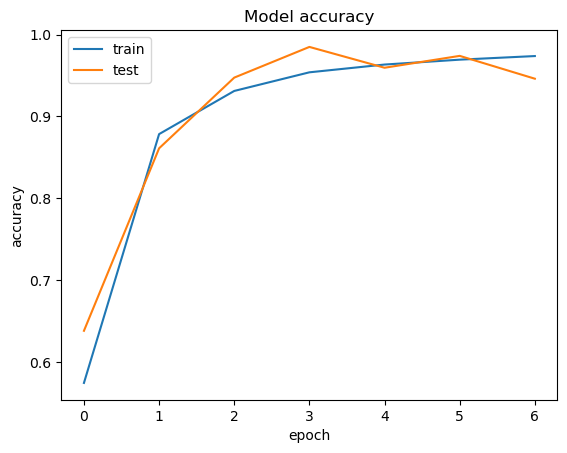

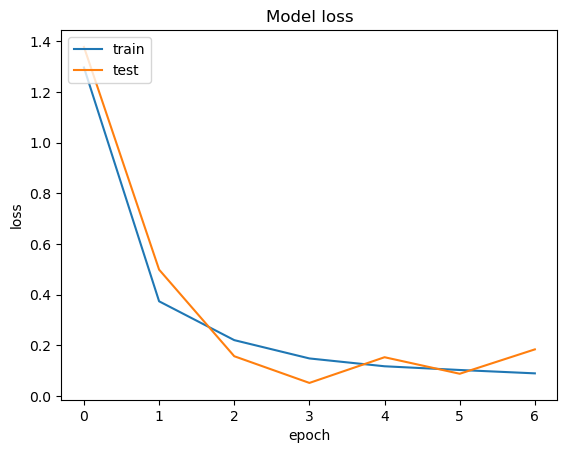

In [11]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history)

In [18]:
# when we run saved model
model_saved = load_model("newmodel_1.h5")

res = model_saved.evaluate(x_train , y_train) 

Accuracy = res[1]

print(f"Train Accuracy = {Accuracy * 100 :.2f} %")

561/561 [==============================] - 44s 78ms/step - loss: 0.0442 - accuracy: 0.9866
Train Accuracy = 98.66 %


In [19]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
   
    y_prediction = model.predict(new_img, batch_size=32, verbose=1)
    predicted_class = np.argmax(y_prediction)
#     print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [20]:
score1 = model_saved.evaluate(x_test, y_test, verbose=1)
print(f'Test Accuracy: { score1[1]*100:.2f} %')

141/141 [==============================] - 11s 78ms/step - loss: 0.0522 - accuracy: 0.9848
Test Accuracy: 98.48 %


1/1 [==============================] - 0s 32ms/step
Predicted: Operating the radio


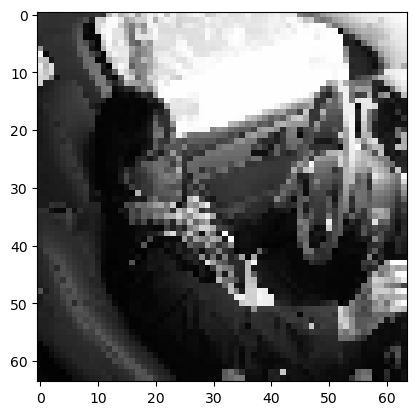

1/1 [==============================] - 0s 28ms/step
Predicted: Operating the radio


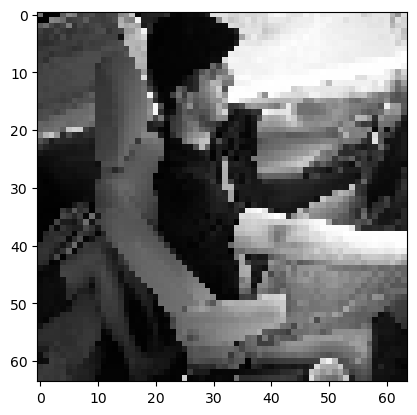

1/1 [==============================] - 0s 28ms/step
Predicted: Safe driving


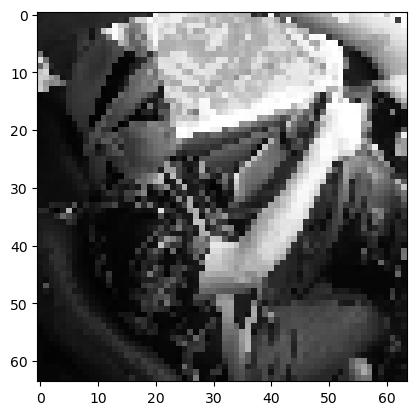

1/1 [==============================] - 0s 32ms/step
Predicted: Hair and makeup


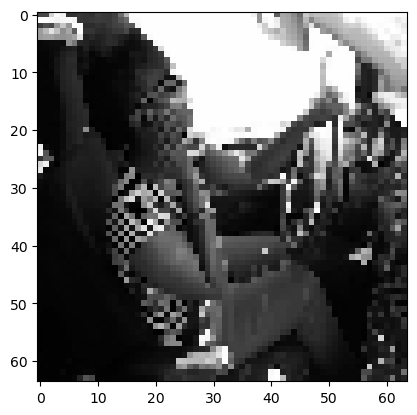

1/1 [==============================] - 0s 36ms/step
Predicted: Talking on the phone - left


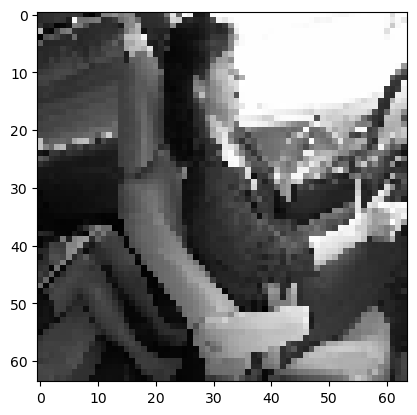

1/1 [==============================] - 0s 29ms/step
Predicted: Texting - left


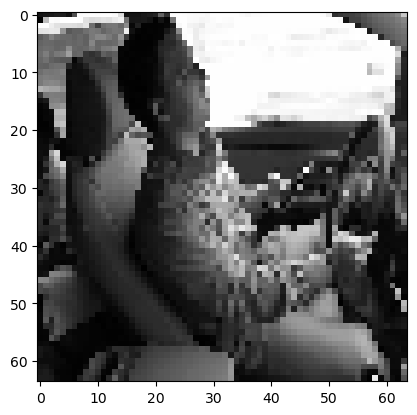

1/1 [==============================] - 0s 27ms/step
Predicted: Drinking


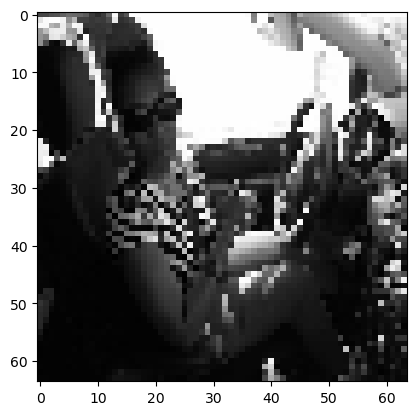

1/1 [==============================] - 0s 30ms/step
Predicted: Talking on the phone - left


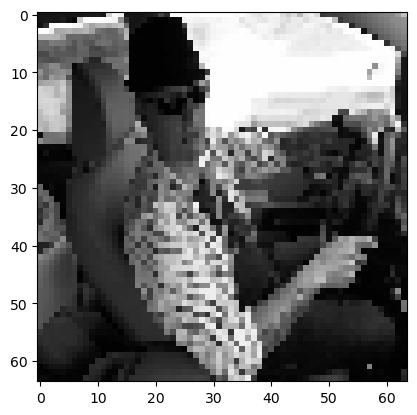

1/1 [==============================] - 0s 29ms/step
Predicted: Drinking


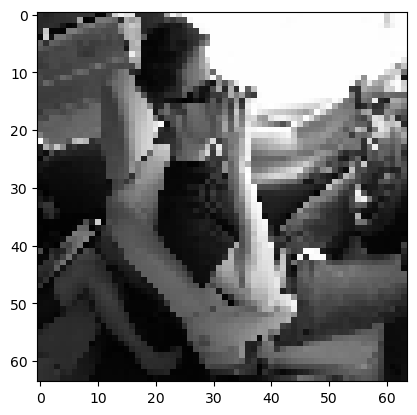

1/1 [==============================] - 0s 28ms/step
Predicted: Reaching behind


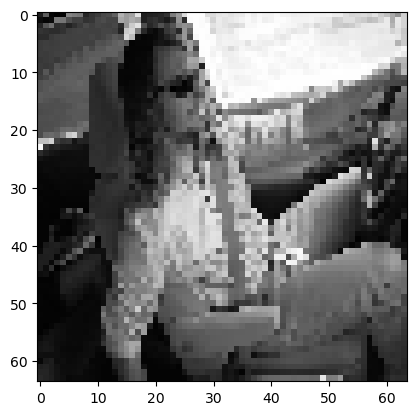

In [16]:
for i in range(10):
    plot_test_class(model_saved, test_files, i)

Prediction

In [25]:
def predict_imgs(model, img_path, img_rows=64, img_cols=64, color_type=1):
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size

    plt.imshow(img, cmap='gray')
    new_img = img.reshape(-1,img_rows,img_cols,color_type)
    y_prediction = model.predict(new_img, batch_size=32, verbose=1)
    predicted_class = np.argmax(y_prediction)
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()



1/1 [==============================] - 0s 29ms/step
Predicted: Reaching behind


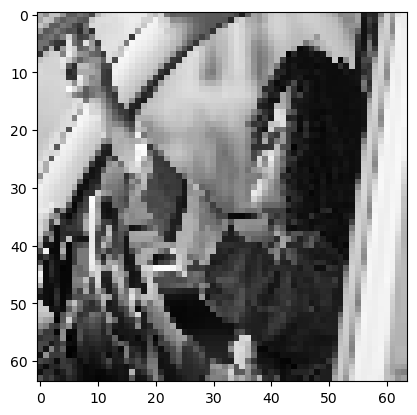

In [27]:
path = "female-driving-car-1200x628-facebook-1200x628.jpg"
predict_imgs(model_saved, path)

1/1 [==============================] - 0s 27ms/step
Predicted: Reaching behind


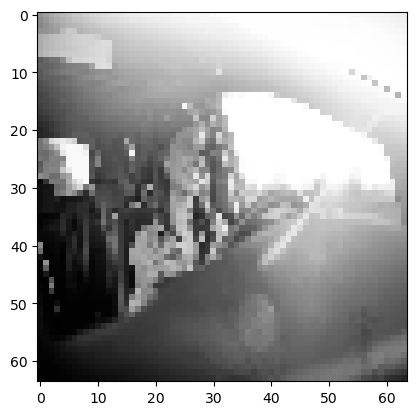

In [28]:
path = "istockphoto-1155392792-612x612.jpg"
predict_imgs(model_saved, path)

1/1 [==============================] - 0s 28ms/step
Predicted: Texting - right


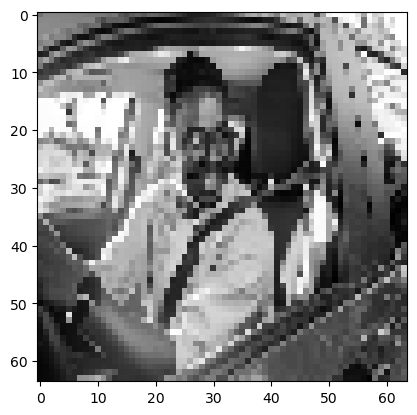

In [29]:
path = "istockphoto-1407921625-612x612.jpg"
predict_imgs(model_saved, path)

1/1 [==============================] - 0s 31ms/step
Predicted: Drinking


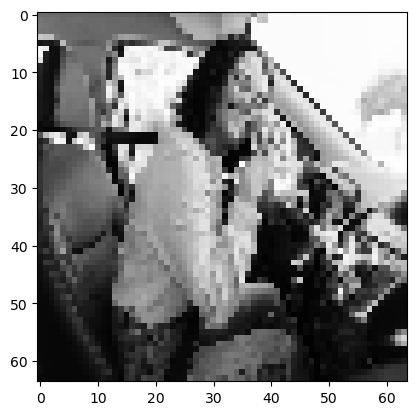

In [31]:
path = "istockphoto-1417064302-612x612.jpg"
predict_imgs(model_saved, path)